In [1]:
import gym
import gymnasium as gym
from gymnasium import Env, spaces
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from plotly.offline import iplot
import plotly.graph_objects as go
import plotly.express as px
import random
import networkx as nx
import matplotlib.patches as mpatches
import torch as th






c:\Users\tass\anaconda3\Lib\site-packages\plotly\express\imshow_utils.py:24: DeprecationWarning:

`np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)



In [2]:
num_drones = 3
limite_y = 80
limite_x = 100
alcance_comunicacao_jammer = 25
alcance_comunicacao_nos = 5000
B_Hz = 2.4e9
posicoes = np.array([[18, 52], [33, 20], [44, 15]])
posicao_jammer = np.array([38, 50])

In [3]:
# Função para calcular a distância entre duas posições
def distancia(pos1, pos2):
    return np.sqrt((pos1[0] - pos2[0])**2 + (pos1[1] - pos2[1])**2)

# Função para encontrar vizinhos dentro do alcance de comunicação
def encontra_vizinhos(posicoes, alcance_comunicacao_nos):
    num_drones = posicoes.shape[0]
    vizinhos = {}
    for i in range(num_drones):
        vizinhos[i] = []
        for j in range(num_drones):
            if i != j and distancia(posicoes[i], posicoes[j]) <= alcance_comunicacao_nos:
                vizinhos[i].append(j)
    return vizinhos

# Função para verificar quais drones são afetados pelo jammer
def verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer):
    afetados_pelo_jammer = []
    for i in range(posicoes.shape[0]):
        if distancia(posicoes[i], posicao_jammer) <= alcance_comunicacao_jammer:
            afetados_pelo_jammer.append(i)
    return afetados_pelo_jammer

# Gera direções aleatórias para as antenas
direcoes_antena = np.random.uniform(0, 360, size=num_drones)
# direcoes_antena = [278, 102, 235, 312, 182, 242]
afetados_pelo_jammer=verifica_jammer(posicoes, posicao_jammer, alcance_comunicacao_jammer)
# Comprimento das setas para indicar a direção das antenas
comprimento_seta = 5

# Criar a figura
fig = go.Figure()

# Adiciona os drones
for i in range(num_drones):
    cor = 'blue' if i in afetados_pelo_jammer else 'blue' # type: ignore
    fig.add_trace(go.Scatter(
        x=[posicoes[i, 0]],
        y=[posicoes[i, 1]],
        mode='markers+text',
        marker=dict(size=10, color=cor),
        text=str(i),
        textposition="bottom center",
        showlegend=False
    ))

    # Calcular as coordenadas da seta para a direção da antena
    direcao_radianos = np.radians(direcoes_antena[i])
    dx = comprimento_seta * np.cos(direcao_radianos)
    dy = comprimento_seta * np.sin(direcao_radianos)
    seta_x = posicoes[i, 0] + dx
    seta_y = posicoes[i, 1] + dy
    
    # Adiciona uma linha para indicar a direção da antena
    fig.add_trace(go.Scatter(
        x=[posicoes[i, 0], seta_x],
        y=[posicoes[i, 1], seta_y],
        mode='lines',
        line=dict(color='black', width=1.5),
        showlegend=False
    ))

# Adiciona o jammer
fig.add_trace(go.Scatter(
    x=[posicao_jammer[0]],
    y=[posicao_jammer[1]],
    mode='markers',
    marker=dict(size=12, color='red'),
    name='Jammer'
))

# Adiciona rastros para a legenda
fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='blue'), name="Drone"))
# fig.add_trace(go.Scatter(x=[None], y=[None], mode='markers', marker=dict(size=10, color='orange'), name="Nó afetado"))

# Configurações do gráfico
fig.update_layout(
    title="Simulação de Modelo de Comunicação Wireless entre Drones",
    xaxis=dict(range=[0, limite_x], autorange=False),
    yaxis=dict(range=[0, limite_y], autorange=False),
    legend_title_text='Legenda',
    legend=dict(traceorder='normal', itemsizing='constant')
)

fig.show()
print(direcoes_antena)

c:\Users\tass\anaconda3\Lib\site-packages\plotly\io\_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



[135.60739677 328.8189588   87.91356039]


In [4]:
# Função para calcular o ângulo entre dois nós em relação à direção da antena
def angulo_entre_nos(pos1, direcao_antena, pos2):
    # Vetor entre os dois nós
    delta_x = pos2[0] - pos1[0]
    delta_y = pos2[1] - pos1[1]
    
    # Direção do vetor em graus
    direcao_vetor_rad = np.arctan2(delta_y, delta_x)
    direcao_vetor_deg = np.degrees(direcao_vetor_rad)
    
    # Diferença entre a direção do vetor e a direção da antena
    angulo = direcao_vetor_deg - direcao_antena
    
    # Ajustar para o intervalo de 0 a 360 graus
    angulo = angulo % 360  # Usa módulo para garantir que o valor esteja entre 0 e 360
    angulo_arredondado = round(angulo)
    
    return angulo_arredondado

# Posições dos drones
# posicoes = np.array([[16, 30], [18, 48], [44, 15], [23, 73], [45, 73], [50, 50]])

# Direções aleatórias das antenas
# direcoes_antena = np.random.uniform(0, 360, size=posicoes.shape[0])

# Matriz para armazenar os ângulos
angulos_matriz = np.zeros((posicoes.shape[0], posicoes.shape[0]))

# Calcular os ângulos para todas as combinações de drones
for i in range(posicoes.shape[0]):
    for j in range(posicoes.shape[0]):
        if i != j:
            angulos_matriz[i, j] = angulo_entre_nos(posicoes[i], direcoes_antena[i], posicoes[j])

# Apresentar os ângulos entre drones sem valores negativos
for i in range(posicoes.shape[0]):
    print(f"Drones que o drone {i} 'vê' com um ângulo:")
    for j in range(posicoes.shape[0]):
        if i != j:
            angulo_arredondado = int(round(angulos_matriz[i, j]))  # Arredondar para unidade
            print(f"  Com o drone {j}: {angulo_arredondado} graus")

Drones que o drone 0 'vê' com um ângulo:
  Com o drone 1: 160 graus
  Com o drone 2: 169 graus
Drones que o drone 1 'vê' com um ângulo:
  Com o drone 0: 146 graus
  Com o drone 2: 7 graus
Drones que o drone 2 'vê' com um ângulo:
  Com o drone 0: 37 graus
  Com o drone 1: 68 graus


In [5]:


Ptx_dBm = 20 
f = 2.4e9 
B_Hz= 2.4e9
d0=1
gamma=2
sigma = 0
c=3e8
lambda_m=c/f
L0=30
potencia_jammer_dBm =100

# Ler o arquivo de ganhos para criar uma tabela de busca
ganhos_df = pd.read_csv('ganhos.csv')


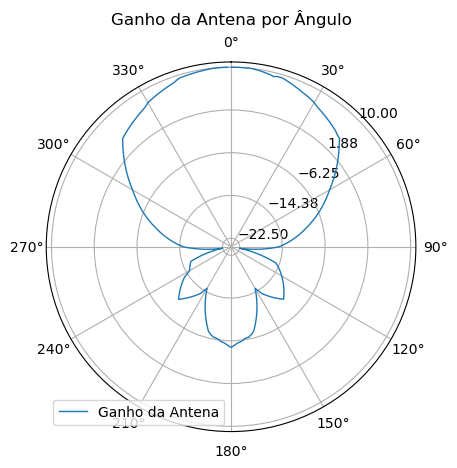

In [6]:
angulos = np.deg2rad(ganhos_df['angulo'])  # Converter graus para radianos
ganhos = ganhos_df['ganho']

# Criar um gráfico polar
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(angulos, ganhos, linestyle='-', linewidth=1, label='Ganho da Antena')

# Ajustar o layout
ax.set_theta_zero_location('N')  # Configurar a direção Norte como o topo do gráfico
ax.set_theta_direction(-1)  # Configurar a direção dos ângulos para sentido horário
ax.set_rmax(max(ganhos) + 1)  # Ajustar o raio máximo para melhor visualização
ax.set_rticks(np.linspace(min(ganhos), max(ganhos), num=5))  # Definir os ticks para o raio
ax.set_rlabel_position(45)  # Posicionar os labels do raio

# Configurar os ticks para o ângulo
ax.set_xticks(np.deg2rad(np.arange(0, 360, 30)))  # Definir marcas de ângulo a cada 30 graus

# Adicionar legenda e título
ax.legend()
ax.set_title('Ganho da Antena por Ângulo', va='bottom')

# Mostrar o gráfico
plt.show()

In [7]:
def busca_ganhos( angulo):
    # Arredondar para o ângulo inteiro mais próximo
    angulo_ajustado = int(round(angulo))
    
    if angulo_ajustado==360:
        angulo_ajustado=0
    
    # Encontrar o ganho correspondente ao ângulo ajustado
    ganho = ganhos_df.loc[ganhos_df['angulo'] == angulo_ajustado, 'ganho'].iloc[0]
    
    return ganho



# Função para calcular os ganhos de transmissão e recepção
def calcula_ganhos(posicoes, direcoes_antena, indice_transmissor, indice_receptor, ganhos_df):
    # Obter posições e direções
    pos1 = posicoes[indice_transmissor]
    pos2 = posicoes[indice_receptor]
    direcao_antena1 = direcoes_antena[indice_transmissor]
    direcao_antena2 = direcoes_antena[indice_receptor]
    
    # Calcular o ângulo entre os dois nós em relação à direção da antena
    angulo_transmissao = angulo_entre_nos(pos1, direcao_antena1, pos2)
    angulo_rececao = angulo_entre_nos(pos2, direcao_antena2, pos1)
    # print('Angulo receção:',angulo_rececao)
    # print('Angulo tranmissão:',angulo_transmissao)

    # Obter os ganhos para transmissão e recepção
    ganho_transmissao = busca_ganhos( angulo_transmissao)
    ganho_rececao = busca_ganhos( angulo_rececao)
    
    return ganho_transmissao, ganho_rececao

# ganho_transmissao, ganho_rececao = calcula_ganhos(posicoes, direcoes_antena, 0, 1, ganhos_df)



def calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d,f):
    """
    Calcula a potência do sinal recebido usando a equação de Friis.
    """
    # L = (4 * np.pi * d / lambda_m)**2
    # Prx_dBm = Ptx_dBm + ganho_transmissao + ganho_rececao - 10 * np.log10(L)
    # return Prx_dBm
    # Calcular a perda de percurso
    if d > 0:
        L = L0 + 10 * gamma * np.log10(d / d0) + np.random.normal(0, sigma)
    else:
        L = L0  # Se a distância for zero, assume-se a perda na distância de referência

    # Calcular a potência do sinal recebido
    Prx_dBm = Ptx_dBm + ganho_transmissao + ganho_rececao - L

    return Prx_dBm

def calcula_potencia_jammer(pos_drone, direcao_antena_drone, pos_jammer, potencia_jammer_dBm, ganhos_df):
    # Calcular a distância entre o drone e o jammer
    d = distancia(pos_drone, pos_jammer)
    
    # Calcular o ângulo entre o drone e o jammer
    angulo_entre_drone_e_jammer = angulo_entre_nos(pos_drone, direcao_antena_drone, pos_jammer)
    
    # Obter o ganho do drone em direção ao jammer
    ganho_drone_para_jammer = busca_ganhos( angulo_entre_drone_e_jammer)
    
    # Calcular a potência do ruído recebido usando a equação de Friis
    L = (4 * np.pi * d / lambda_m) ** 2  # Perda de propagação
    potencia_jammer_recebida_dBm = potencia_jammer_dBm + ganho_drone_para_jammer - 10 * np.log10(L)
    
    return potencia_jammer_recebida_dBm

def calcula_capacidade(potencia_sinal_dBm, potencia_ruido_dBm):
    """
    Calcula a capacidade do canal em bits por segundo usando a fórmula de Shannon-Hartley.
    """
    # Converter potência em dBm para Watts
    potencia_sinal_W = 10 ** (potencia_sinal_dBm / 10) / 1000  # Potência do sinal em Watts
    potencia_ruido_W = 10 ** (potencia_ruido_dBm / 10) / 1000  # Potência do ruído em Watts
    
    # Calcular a razão sinal-ruído (SNR)
    snr = potencia_sinal_W / potencia_ruido_W
    
    # Calcular a capacidade do canal em bits por segundo (bps)
    capacidade = B_Hz * np.log2(1 + snr)
    
    return capacidade/1e3

# -------------------------------------------------------------------------------------------------------------
# -------------------------------------------------------------------------------------------------------------
for i in range(posicoes.shape[0]):
    for j in range(posicoes.shape[0]):
        if i != j:
            # Calcular a distância entre os dois drones
            d = distancia(posicoes[i], posicoes[j])
            
            # Calcular os ganhos de transmissão e recepção
            ganho_transmissao, ganho_rececao = calcula_ganhos(posicoes, direcoes_antena, i, j, ganhos_df)
            # print(posicoes)
            print('Ganhos Rx,Tx:',ganho_transmissao, ganho_rececao)
            # Calcular a potência do sinal recebido usando a equação de Friis
            potencia_recebida = calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d, lambda_m)
            potencia_ruido = calcula_potencia_jammer(posicoes[j], direcoes_antena[j], posicao_jammer, potencia_jammer_dBm, ganhos_df)
            capacidade_canal=calcula_capacidade(potencia_recebida,potencia_ruido)
            # Imprimir a combinação de nós e a potência do sinal recebido
            print(f"  Potencia recebida do drone {i} para o drone {j}: {potencia_recebida:.2f} dBm")
            print(f"  Ruido recebido no drone {j} e do jammer: {potencia_ruido:.2f} dBm")
            print(f"  Capacidade do canal {i} para {j}: {capacidade_canal:.2f} bps")

Ganhos Rx,Tx: -10.0 -13.3
  Potencia recebida do drone 0 para o drone 1: -64.27 dBm
  Ruido recebido no drone 1 e do jammer: 15.69 dBm
  Capacidade do canal 0 para 1: 0.03 bps
Ganhos Rx,Tx: -6.6 6.3
  Potencia recebida do drone 0 para o drone 2: -43.41 dBm
  Ruido recebido no drone 2 e do jammer: 38.45 dBm
  Capacidade do canal 0 para 2: 0.02 bps
Ganhos Rx,Tx: -13.3 -10.0
  Potencia recebida do drone 1 para o drone 0: -64.27 dBm
  Ruido recebido no drone 0 e do jammer: 22.09 dBm
  Capacidade do canal 1 para 0: 0.01 bps
Ganhos Rx,Tx: 9.96 -5.94
  Potencia recebida do drone 1 para o drone 2: -27.62 dBm
  Ruido recebido no drone 2 e do jammer: 38.45 dBm
  Capacidade do canal 1 para 2: 0.86 bps
Ganhos Rx,Tx: 6.3 -6.6
  Potencia recebida do drone 2 para o drone 0: -43.41 dBm
  Ruido recebido no drone 0 e do jammer: 22.09 dBm
  Capacidade do canal 2 para 0: 0.98 bps
Ganhos Rx,Tx: -5.94 9.96
  Potencia recebida do drone 2 para o drone 1: -27.62 dBm
  Ruido recebido no drone 1 e do jammer: 15.

DRL

In [8]:
seed=0


# Definindo valores de direção discretos (10 valores)
direcoes_discretas = np.linspace(0, 360, 10, endpoint=False)



class UAVCommunicationEnv(gym.Env):
    metadata = {'render.modes': ['human']}

    def __init__(self, num_uavs=num_drones, area_size=(100, 100)):
        super().__init__()
        self.num_uavs = num_uavs
        self.area_size = area_size
        self.posicoes = posicoes
        self.posicao_jammer = posicao_jammer
        self.ultimo_info = {}
        self.max_steps = 1000
        self.current_step = 0

        # Define o espaço de ação como direções discretas para cada drone
        self.action_space = spaces.MultiDiscrete([len(direcoes_discretas)] * num_uavs)
        self.observation_space = spaces.MultiDiscrete([360] * num_uavs)
        self.direcoes_antena = np.random.choice(direcoes_discretas, size=num_uavs)
        self.capacidades = []  # Inicializa a lista de capacidades para normalização

    def step(self, action):
        self.current_step += 1
        self.direcoes_antena = direcoes_discretas[np.array(action)]
        
        total_capacidades = 0
        capacidades_por_link = []

        # Iterar por todos os drones para calcular a capacidade entre eles
        for i in range(self.posicoes.shape[0]):
            for j in range(self.posicoes.shape[0]):
                if i != j:
                    d = distancia(self.posicoes[i], self.posicoes[j])
                    ganho_transmissao, ganho_rececao = calcula_ganhos(self.posicoes, self.direcoes_antena, i, j, ganhos_df)
                    potencia_recebida = calcula_potencia_recebida(Ptx_dBm, ganho_transmissao, ganho_rececao, d, lambda_m)
                    potencia_ruido = calcula_potencia_jammer(self.posicoes[j], self.direcoes_antena[j], self.posicao_jammer, potencia_jammer_dBm, ganhos_df)
                    capacidade_canal = calcula_capacidade(potencia_recebida, potencia_ruido)
                    capacidades_por_link.append(capacidade_canal)
                    total_capacidades += capacidade_canal

        capacidade_media = np.mean(capacidades_por_link)
        capacidade_minima = np.min(capacidades_por_link)

        # Armazenar capacidades para normalização
        self.capacidades.extend(capacidades_por_link)
        if len(self.capacidades) > 1000:  # Manter apenas as últimas 1000 capacidades
            self.capacidades = self.capacidades[-1000:]

        # Normalização das capacidades
        min_capacidade = np.min(self.capacidades)
        max_capacidade = np.max(self.capacidades)
        capacidade_media_normalizada = (capacidade_media - min_capacidade) / (max_capacidade - min_capacidade + 1e-6)
        capacidade_minima_normalizada = (capacidade_minima - min_capacidade) / (max_capacidade - min_capacidade + 1e-6)

        # Com Normalização
        recompensa = 0.8 * capacidade_media_normalizada + 0.2 * capacidade_minima_normalizada
        
        # Sem Normalização
        # recompensa = 1.0 * capacidade_media + 0.0 * capacidade_minima

        capacidades_por_link = [round(capacidade, 3) for capacidade in capacidades_por_link]
        capacidade_media = round(capacidade_media, 3)
        
        capacidade_matriz = np.zeros((self.num_uavs, self.num_uavs))
        link_index = 0

        for i in range(self.num_uavs):
            for j in range(self.num_uavs):
                if i != j:
                    capacidade_matriz[i, j] = capacidades_por_link[link_index]
                    link_index += 1

        info = {
            'Recompensa': recompensa,
            'Capacidade média [Kbps]': capacidade_media,
            'Capacidades_por_link [Kbps]': capacidades_por_link,
            'Matriz de Capacidades [Kbps]': capacidade_matriz,
            'Capacidade mínima [Kbps]': capacidade_minima,
            'Capacidade média normalizada': capacidade_media_normalizada,
            'Capacidade mínima normalizada': capacidade_minima_normalizada
        }

        terminated = self.current_step >= self.max_steps
        truncated = False  # Neste exemplo, não estamos truncando o episódio

        return np.array(self.direcoes_antena, dtype=np.int64), recompensa, terminated, truncated, info
    
    def render(self, mode='human'):
        sns.set(style="whitegrid")
        fig, ax = plt.subplots(figsize=(9, 4))

        # Desenha os drones no gráfico
        for i, pos in enumerate(self.posicoes):
            ax.scatter(pos[0], pos[1], color='blue', s=100, label='Drone' if i == 0 else "")
            ax.text(pos[0], pos[1] - 2, f'{i}', horizontalalignment='center', color='white', fontweight='bold')

        # Desenha as setas para a direção das antenas
        comprimento_seta = 5  # Comprimento das setas
        for i, direcao in enumerate(self.direcoes_antena):
            direcao_rad = np.radians(direcao)  # Converte para radianos
            dx = comprimento_seta * np.cos(direcao_rad)  # Deslocamento em x
            dy = comprimento_seta * np.sin(direcao_rad)  # Deslocamento em y
            
            ax.arrow(
                self.posicoes[i][0], self.posicoes[i][1], 
                dx, dy, 
                head_width=2, head_length=2, fc='b', ec='b'
            )  # Seta azul para indicar a direção da antena

        # Desenha o jammer
        ax.scatter(self.posicao_jammer[0], self.posicao_jammer[1], color='red', s=100, marker='o', label='Jammer')

        # Configurações finais do gráfico
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_xlim(0, self.area_size[0])
        ax.set_ylim(0, self.area_size[1])
        plt.title('Direções das Antenas UAV')
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

        plt.show()
        
    def reset(self, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.direcoes_antena = np.random.choice(direcoes_discretas, size=self.num_uavs)
        self.current_step = 0
        assert len(self.direcoes_antena) == self.num_uavs, "Número incorreto de direções"
        obs = np.array(self.direcoes_antena, dtype=np.int64)
        return obs, {}

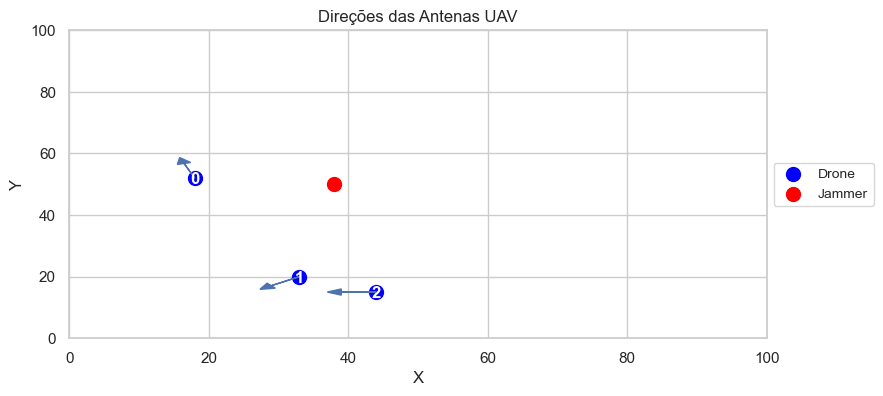

Direções Estabelecidas:
 [108 216 180]

Recompensa:
 0.218618668730532

Capacidade Média [Kbps]: 3.51

Capacidade Minima [Kbps]: 0.004060362311763681

Capacidade por Link [Kbps]: [0.004, 0.384, 0.006, 12.834, 0.355, 7.478]

Matriz de Capacidades [Kbps]: 	0.00 0.00 0.38
	0.01 0.00 12.83
	0.35 7.48 0.00


In [9]:
env = UAVCommunicationEnv()

state = env.reset()
done = False
while not done:
    action = env.action_space.sample()  # Escolha uma ação aleatoriamente
    state, reward,terminated,truncated, info = env.step(action)
    env.render()  # Chame render a cada passo para visualizar
    
    print('Direções Estabelecidas:\n', state)
    print("\nRecompensa:\n", reward)
    if 'Capacidade média [Kbps]' in info:
        print("\nCapacidade Média [Kbps]:", info['Capacidade média [Kbps]'])
    if 'Capacidade média [Kbps]' in info:
        print("\nCapacidade Minima [Kbps]:", info['Capacidade mínima [Kbps]'])
    if 'Capacidades_por_link [Kbps]' in info:
        print("\nCapacidade por Link [Kbps]:", info['Capacidades_por_link [Kbps]'])
    if 'Matriz de Capacidades [Kbps]' in info:
        # capacidade_matriz=info['Matriz de Capacidades [Kbps]']
        print("\nMatriz de Capacidades [Kbps]:", '\n'.join(['\t' + ' '.join(f"{item:.2f}" for item in row) for row in info['Matriz de Capacidades [Kbps]']]))
    else:
        print("Chave 'Matriz de Capacidades [Kbps]' não encontrada em info.")
    done = True

PPO(Proximal Policy Optimization) ALGORITHM

Explora politicas em vez de atribuir valores aos pares estado-ação

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | 8.86     |
| time/              |          |
|    fps             | 163      |
|    iterations      | 1        |
|    time_elapsed    | 12       |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | 8.98        |
| time/                   |             |
|    fps                  | 152         |
|    iterations           | 2           |
|    time_elapsed         | 26          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011460858 |
|    clip_fraction        | 0.093       |
|    clip_range           | 0.2         |
|    entropy_loss   

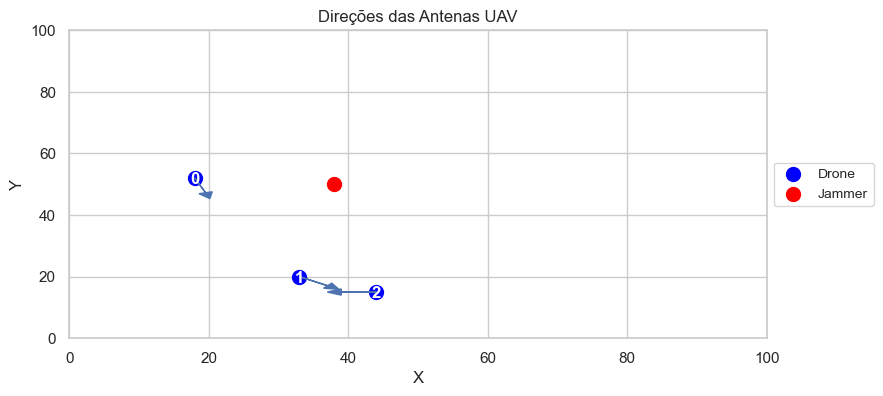

Direções Estabelecidas:
 [288 324 180]

Recompensa:
 0.17706297002834326

Capacidade Média do Melhor Estado: 892.367 Kbps
Capacidade Mínima do Melhor Estado: 0.12817531771241147 Kbps

Matriz de Capacidades [Kbps] do Melhor Estado:
 [[0.000000e+00 2.087000e+00 2.366000e+01]
 [1.280000e-01 0.000000e+00 2.281417e+03]
 [1.939000e+00 3.044973e+03 0.000000e+00]]


In [10]:
# Verifique o ambiente
env = UAVCommunicationEnv()
check_env(env)

# Treinar o modelo PPO
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# Avaliar o modelo
# mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)

# Carregar o modelo e testar
model = PPO.load("ppo_uav_communication")
state, _ = env.reset()
done = False

best_state = None
best_reward = -np.inf
total_reward = 0
best_info = {}

while not done:
    action, _ = model.predict(state)
    state, reward, terminated, truncated, info = env.step(action)
    
    if reward > best_reward:
        best_reward = reward
        best_state = state
        best_info = info
    done = terminated or truncated

# Renderizar o melhor estado
env.direcoes_antena = best_state
env.render()
print('Direções Estabelecidas:\n', best_state)
print("\nRecompensa:\n", best_reward)
print(f"\nCapacidade Média do Melhor Estado: {best_info['Capacidade média [Kbps]']} Kbps")
print(f"Capacidade Mínima do Melhor Estado: {best_info['Capacidade mínima [Kbps]']} Kbps")
print(f"\nMatriz de Capacidades [Kbps] do Melhor Estado:\n {best_info['Matriz de Capacidades [Kbps]']}")


PPO COM DATA DE TREINO

In [11]:
import pandas as pd

# Carregar os dados do CSV
df = pd.read_csv('resultados_uav.csv')

# Converter a coluna de direções de string para lista
df['Direcoes'] = df['Direcoes'].apply(lambda x: list(map(int, x.strip('[]').split(','))))

# Visualizar os primeiros dados
print(df.head())


          Direcoes  Recompensa  Capacidade_Media_Kbps  Capacidade_Minima_Kbps
0  [157, 148, 272]    0.375993                  0.135                0.000812
1    [79, 285, 32]    0.226677                  0.761                0.001489
2  [213, 286, 314]    0.270516                  2.470                0.005244
3  [140, 169, 303]    0.030858                  0.282                0.075801
4   [36, 119, 302]    0.002363                  0.022                0.000144


Using cpu device
----------------------------
| time/              |     |
|    fps             | 152 |
|    iterations      | 1   |
|    time_elapsed    | 3   |
|    total_timesteps | 512 |
----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 148          |
|    iterations           | 2            |
|    time_elapsed         | 6            |
|    total_timesteps      | 1024         |
| train/                  |              |
|    approx_kl            | 0.0009582882 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -6.91        |
|    explained_variance   | -0.397       |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0103      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0103      |
|    value_loss           | 0.0232       |
------------------------------------------
------

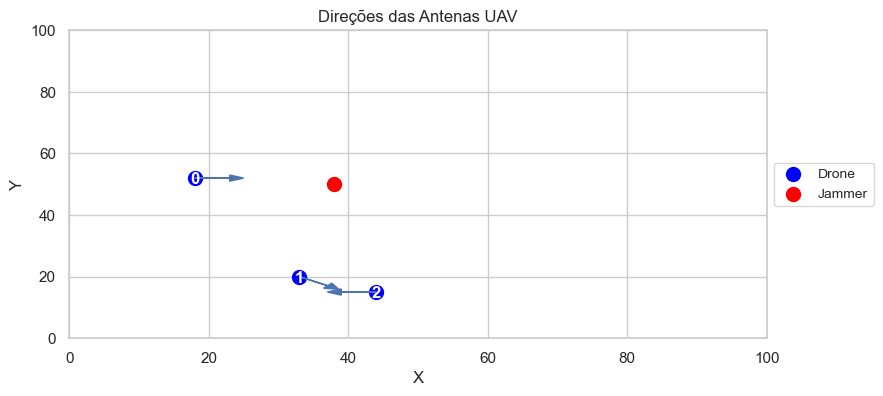

Direções Estabelecidas:
 [  0 324 180]

Recompensa:
 0.2333544643772769

Capacidade Média do Melhor Estado: 888.198 Kbps
Capacidade Mínima do Melhor Estado: 0.00013925295011803424 Kbps

Matriz de Capacidades [Kbps] do Melhor Estado:
 [[0.000000e+00 7.200000e-02 2.716000e+00]
 [0.000000e+00 0.000000e+00 2.281417e+03]
 [7.000000e-03 3.044973e+03 0.000000e+00]]


In [16]:
def make_env(seed):
    def _init():
        env = UAVCommunicationEnv()
        env = Monitor(env)
        return env
    return _init

# Definindo o ambiente paralelo usando DummyVecEnv
n_envs = 2
envs = DummyVecEnv([make_env(i) for i in range(n_envs)])

# Função de pré-treinamento
def pre_train(model, envs, pre_train_data, pre_train_iters=100):
    max_pretrain_steps = 5  # Definindo um número máximo de passos para terminar o episódio
    for pre_train_iter in range(pre_train_iters):
        print(f"Pre-train iteration {pre_train_iter+1}/{pre_train_iters}")
        for data_index, (action, reward) in enumerate(pre_train_data):
            print(f"Pre-train data index {data_index+1}/{len(pre_train_data)}")
            # Converter a ação para índices discretos
            action = np.array(action) % len(direcoes_discretas)
            obs = envs.reset()
            done = np.zeros(n_envs, dtype=bool)
            step_count = 0  # Contador de passos
            while not np.any(done) and step_count < max_pretrain_steps:
                # print(f"Step count {step_count}")
                model.policy.set_training_mode(False)
                predicted_action, _ = model.predict(obs, deterministic=True)
                obs_tensor = th.tensor(obs, dtype=th.float32).to(model.device)
                predicted_action_tensor = th.tensor(predicted_action, dtype=th.float32).to(model.device)
                obs, _, done, _ = envs.step([action] * n_envs)
                model.policy.set_training_mode(True)
                model.policy.optimizer.zero_grad()
                values, log_prob, entropy = model.policy.evaluate_actions(obs_tensor, predicted_action_tensor)
                policy_loss = -log_prob.mean()
                value_loss = th.nn.functional.mse_loss(values.flatten(), th.tensor([reward] * n_envs, dtype=th.float32).to(model.device))
                loss = policy_loss + value_loss
                loss.backward()
                model.policy.optimizer.step()
                step_count += 1  # Incrementa o contador de passos

# Carregar os dados do CSV
df = pd.read_csv('resultados_uav.csv')

# Converter a coluna de direções de string para lista
df['Direcoes'] = df['Direcoes'].apply(lambda x: list(map(int, x.strip('[]').split(','))))

# Dados de pré-treinamento (ações e recompensas)
pre_train_data = list(zip(df['Direcoes'], df['Recompensa']))

# Treinamento do modelo PPO com pré-treinamento
model = PPO("MlpPolicy", envs, verbose=1, n_steps=256, batch_size=128, learning_rate=3e-4)

model.learn(total_timesteps=50000)
# Pré-treinamento
pre_train(model, envs, pre_train_data, pre_train_iters=10)
# model.learn(total_timesteps=10000)

# Treinamento do modelo
# model.learn(total_timesteps=20000)

# Avaliação do modelo para encontrar o melhor episódio
best_reward = -np.inf
best_state = None
best_info = None
done = False
state = env.reset()[0]

while not done:
    action, _ = model.predict(state)
    state, reward, terminated, truncated, info = env.step(action)

    if reward > best_reward:
        best_reward = reward
        best_state = state
        best_info = info
    done = terminated or truncated

# Renderizar o melhor estado
env.direcoes_antena = best_state
env.render()
print('Direções Estabelecidas:\n', best_state)
print("\nRecompensa:\n", best_reward)
print(f"\nCapacidade Média do Melhor Estado: {best_info['Capacidade média [Kbps]']} Kbps")
print(f"Capacidade Mínima do Melhor Estado: {best_info['Capacidade mínima [Kbps]']} Kbps")
print(f"\nMatriz de Capacidades [Kbps] do Melhor Estado:\n {best_info['Matriz de Capacidades [Kbps]']}")

capacidade_matriz=best_info['Matriz de Capacidades [Kbps]']

ALGORITMO DIJKSTRA

https://www.w3schools.com/dsa/dsa_algo_graphs_dijkstra.php

In [14]:
# Criar um grafo
G = nx.Graph()

# Adicionar arestas ao grafo com o inverso das capacidades como pesos
num_drones = posicoes.shape[0]
for i in range(num_drones):
    for j in range(i + 1, num_drones):
        capacidade = capacidade_matriz[i, j]
        G.add_edge(i, j, weight=1.0 / capacidade)  # Usando o inverso das capacidades como peso

# Calcular o caminho mais curto usando Dijkstra para cada par de nós
bottlenecks = {}
for i in range(num_drones):
    for j in range(num_drones):
        if i != j:
            try:
                caminho = nx.dijkstra_path(G, source=i, target=j, weight='weight')
                # Encontrar o bottleneck no caminho
                menor_capacidade = float('inf')
                for k in range(len(caminho) - 1):
                    cap_atual = capacidade_matriz[caminho[k], caminho[k+1]]
                    if cap_atual < menor_capacidade:
                        menor_capacidade = cap_atual
                bottlenecks[(i, j)] = (caminho, menor_capacidade)
            except nx.NetworkXNoPath:
                print(f"Não há caminho do nó {i} para o nó {j}")

# Imprimir os caminhos e o bottleneck de cada um
for key, (caminho, bottleneck) in bottlenecks.items():
    print(f"Caminho do nó {key[0]} para o nó {key[1]}: {caminho}, Bottleneck: {bottleneck:.3f}")


NameError: name 'capacidade_matriz' is not defined